<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Прогнозирование-использования-вычислительных-ресурсов-в-кластере-k8s" data-toc-modified-id="Прогнозирование-использования-вычислительных-ресурсов-в-кластере-k8s-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Прогнозирование использования вычислительных ресурсов в кластере k8s</a></span><ul class="toc-item"><li><span><a href="#Загрузка-библиотек-и-функций" data-toc-modified-id="Загрузка-библиотек-и-функций-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка библиотек и функций</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Функции-загрузки" data-toc-modified-id="Функции-загрузки-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Функции загрузки</a></span></li><li><span><a href="#Загрузка-данных-по-месяцам" data-toc-modified-id="Загрузка-данных-по-месяцам-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Загрузка данных по месяцам</a></span></li><li><span><a href="#Объединение-данных-по-году" data-toc-modified-id="Объединение-данных-по-году-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Объединение данных по году</a></span></li><li><span><a href="#Консолидация-метрик-по-поду" data-toc-modified-id="Консолидация-метрик-по-поду-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Консолидация метрик по поду</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Исследовательский анализ</a></span></li><li><span><a href="#Добавление-признаков" data-toc-modified-id="Добавление-признаков-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Добавление признаков</a></span></li><li><span><a href="#Подготовка-пайплайна" data-toc-modified-id="Подготовка-пайплайна-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Подготовка пайплайна</a></span></li><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li><li><span><a href="#Расчет-ориентира-контрольной-метрики" data-toc-modified-id="Расчет-ориентира-контрольной-метрики-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Расчет ориентира контрольной метрики</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></li></ul></div>

## Прогнозирование использования вычислительных ресурсов в кластере k8s

В этом проекте мы исследуем возможность прогнозирования объема фактического потребления vCPU контейнерами приложений, запускаемых в кластере Kubernetes.\
Цель данного исследования - создание прототипа вычислительного ядра системы предсказательного мониторинга, которая позволит оптимизировать баланс реквестов и фактического потребления вычислительного ресурса в кластере. 

### Загрузка библиотек и функций

In [2]:
!pip install --upgrade scikit-learn -q

In [3]:
#базовые
import pandas as pd
import numpy as np
import re
#генерация случайных чисел
import random
#учет времени выполнения
import time
# отключение ошибок
import warnings
# графики
import seaborn as sns
import matplotlib.pyplot as plt
# преобразование данных
from sklearn.model_selection import train_test_split, TimeSeriesSplit
# Модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
#проверка адекватности модели
from sklearn.dummy import DummyRegressor
# Метрики
from sklearn.metrics import root_mean_squared_error
# Инструменты подбора гиперпараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
# пайплайны
from sklearn.pipeline import Pipeline
#временные ряды
from statsmodels.tsa.seasonal import seasonal_decompose

RANDOM_STATE = 88

In [4]:
#функция печати графиков для исследовательского анализа данных
def stat_plots(df, custom_bins={}, countplots=[]):
    for column in countplots:
        data = df[column]
        sns.countplot(data, palette='GnBu_r')
        plt.title(f'Количественный анализ дискретного признака {column}')
        plt.xlabel('Значения')
        plt.ylabel('Количество')
        plt.show()
    df = df.drop(countplots, axis=1)    
    for column in df.select_dtypes(include='number').columns:
        try:
            nbins = custom_bins[column]
        except:
            nbins = 10
        ind_label = df[column].name
        print('=' * 110)
        print(f'Статистический анализ показателя {ind_label}')
        print('-' * 110)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,2))
        bins = axes[0].hist(df[column], bins=nbins)
        axes[0].vlines(x=df[column].mean(), colors='red', ymin=0, ymax=bins[0].max(), label='Среднее')
        axes[0].vlines(x=df[column].median(), colors='red', ymin=0, ymax=bins[0].max(), linestyles='--', label='Медиана')
        axes[0].set_title('Гистограмма распределения')
        axes[0].set_xlabel(ind_label)
        axes[0].set_ylabel('Количество значений')
        axes[0].legend()
        axes[1].boxplot(df[column], vert=False)
        axes[1].set_title('Диаграмма размаха')
        axes[1].set_xlabel(ind_label)
        plt.show()
    for column in df.select_dtypes(include='object').columns:
        ind_label = df[column].name
        df[column].value_counts().plot(kind='pie', autopct='%.0f', subplots=True, legend=False, label=ind_label)
        plt.title(f'Распределение долей по показателю {ind_label}')
        plt.show()

### Загрузка данных

#### Функции загрузки

Функция load_data загружает файл csv, полученный из БД Prometheus и конвертирует его в формат, необходимый для дальнейшей обработки:

In [5]:
def load_data(file_name, dates=1):
    start = time.time()
    dataframe = pd.read_csv(file_name, parse_dates=[dates]).sort_values(by='datetime').reset_index(drop=True)
    dataframe.value = dataframe.value.round(3)
    dataframe.datetime = dataframe.datetime.dt.round('1T')
    dataframe = dataframe[['datetime', 'value', 'container_name', 'pod_name']]
    end = time.time()
    print(f'Файл {file_name} успешно загружен за {round((end-start), 2)} сек.')
    return dataframe

Функция update_pods_list добавляет уникальные сочетания подов и контейнеров из файла данных в единый реестр

In [6]:
def update_pods_list(df, registry):
    registry = pd.concat((registry, df[['container_name', 'pod_name']]), axis=0)
    registry = registry.drop_duplicates().sort_values(by='container_name').reset_index(drop=True)
    print(f'В реестре подов {len(registry)} записей.')
    return registry

Функция get_pod_id выполняет сопоставление названия пода и названия контейнера строке реестра подов

In [7]:
def get_pod_id(row):
    pod_id = pods_registry[
        (pods_registry.container_name == row.container_name)
        & (pods_registry.pod_name == row.pod_name)].index[0]
    return pod_id

Функция mark_pods размечает файл данных уникальными идентификаторами под/контейнер

In [8]:
def mark_pods(df):
    start = time.time()
    df['pod_id'] = df.apply(get_pod_id, axis=1)
    end = time.time()
    print(f'Маркировка подов выполнена за {round((end-start), 2)} сек.')
    return df

Функция load_period загружает файлы по всем метрикам за определенный период

In [9]:
pods_registry = pd.DataFrame(columns=['container_name', 'pod_name'])

def load_period(sources, pods_registry):
    cpu_request=pd.DataFrame()
    cpu_req_util=pd.DataFrame()
    cpu_usage_time=pd.DataFrame()
    metrics = [cpu_request, cpu_req_util, cpu_usage_time]

    for i in range(0, len(sources)):
        metrics[i] = load_data(sources[i])
        pods_registry = update_pods_list(metrics[i], pods_registry)
    return metrics, pods_registry

#### Загрузка данных по месяцам

Зададим в качестве источника Prometheus выгрузки за сентябрь и октябрь

In [10]:
monthly_sources = [
    ['cpu_request_09.csv', 'cpu_util_09.csv', 'cpu_usage_09.csv'],
    ['cpu_request_10.csv', 'cpu_req_util_10.csv', 'cpu_usage_time_10.csv']
]

Загрузим данные из источника с одновременным формированием реестра подов/контейнеров и разметкой файлов данный уникальными идентификаторами из этого реестра.

In [11]:
monthly_metrics = []
for month in monthly_sources:
    metrics_month, pods_registry = load_period(month, pods_registry)
    for metric in metrics_month:
        mark_pods(metric)
    monthly_metrics.append(metrics_month)

Файл cpu_request_09.csv успешно загружен за 0.63 сек.
В реестре подов 471 записей.
Файл cpu_util_09.csv успешно загружен за 0.63 сек.
В реестре подов 471 записей.
Файл cpu_usage_09.csv успешно загружен за 0.63 сек.
В реестре подов 479 записей.
Маркировка подов выполнена за 84.63 сек.
Маркировка подов выполнена за 75.37 сек.
Маркировка подов выполнена за 84.64 сек.
Файл cpu_request_10.csv успешно загружен за 0.64 сек.
В реестре подов 936 записей.
Файл cpu_req_util_10.csv успешно загружен за 0.62 сек.
В реестре подов 936 записей.
Файл cpu_usage_time_10.csv успешно загружен за 0.78 сек.
В реестре подов 937 записей.
Маркировка подов выполнена за 96.83 сек.
Маркировка подов выполнена за 86.48 сек.
Маркировка подов выполнена за 97.14 сек.


#### Объединение данных по году

Объединим данные по месяцам в единый датасет для каждой метрики Prometheus

In [12]:
dataset = []
m = 0
for i in range(0, len(monthly_sources) - 1):
    annual_metrics = []
    for m in range(0, 3):
        long_metric = pd.concat([monthly_metrics[i][m], monthly_metrics[i+1][m]], axis=0)
        annual_metrics.append(long_metric)
    dataset.append(annual_metrics)

#### Консолидация метрик по поду

Функция compile_pod_metrics консолидирует все загруженные метрики Prometheus в единый файл данных для конкретного контейнера определенного пода. 

In [13]:
def compile_pod_metrics(pod_id):
    base = dataset[0][0]
    timeline = base[base['pod_id'] == pod_id].sort_values(by='datetime').set_index('datetime').index
    pod_data = pd.DataFrame(index=timeline)
    col_names = ['cpu_request', 'cpu_req_util', 'cpu_usage_time']
    i = 0
    for df in dataset[0]:
        metric = df[df['pod_id'] == pod_id][['datetime', 'value']].sort_values(by='datetime').set_index('datetime')
        metric.columns = metric.columns.str.replace('value', col_names[i])
        pod_data = pod_data.join(metric, how='left')
        i += 1
    return pod_data

Сформируем датасет из метрик для одного из контейнеров:

In [14]:
data = compile_pod_metrics(0)
data

,cpu_request,cpu_req_util,cpu_usage_time
datetime,,,
2024-09-17 15:07:00,2.0,0.134,0.563
2024-09-17 15:17:00,2.0,0.153,0.548
2024-09-17 15:27:00,2.0,0.154,0.556
2024-09-17 15:37:00,2.0,0.128,0.565
2024-09-17 15:47:00,2.0,0.202,0.564
...,...,...,...
2024-11-16 14:17:00,2.0,0.163,0.477
2024-11-16 14:27:00,2.0,0.113,0.498
2024-11-16 14:37:00,2.0,0.154,0.467


### Исследовательский анализ

Изучим распределения метрик для выбранного контейнера и пода:

Статистический анализ показателя cpu_request
--------------------------------------------------------------------------------------------------------------


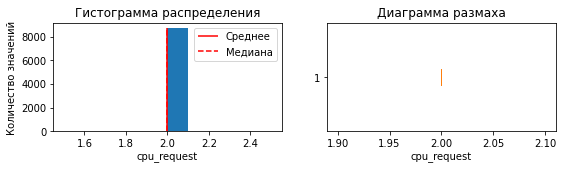

Статистический анализ показателя cpu_req_util
--------------------------------------------------------------------------------------------------------------


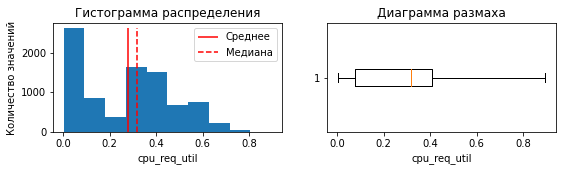

Статистический анализ показателя cpu_usage_time
--------------------------------------------------------------------------------------------------------------


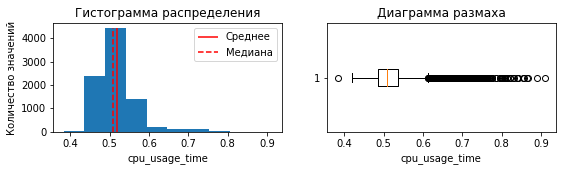

In [15]:
stat_plots(data)

Изучим исследуемый временной ряд на предмет стационарности

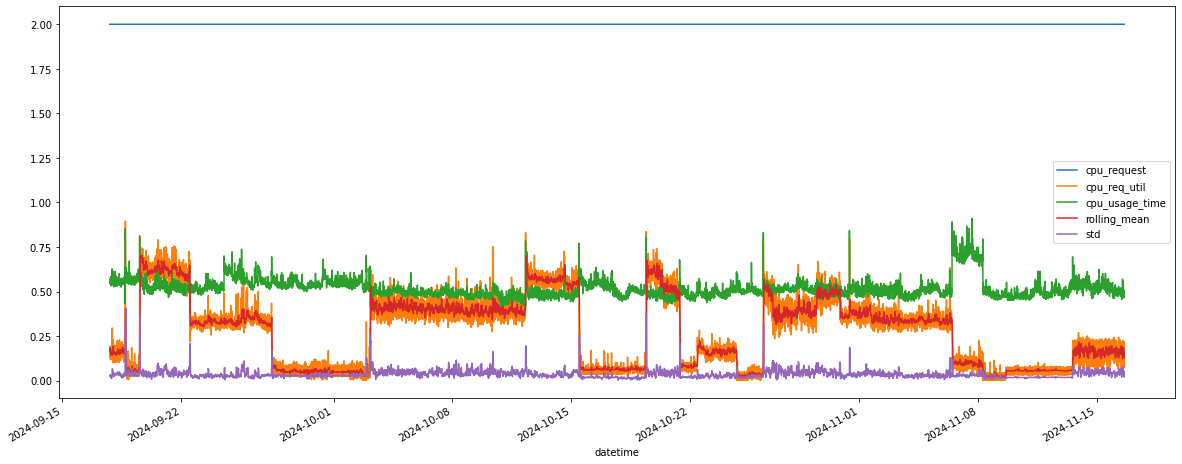

In [16]:
data['rolling_mean'] = data.cpu_req_util.shift().rolling(6).mean()
data['rolling_mean'] = data['rolling_mean'].fillna(0)
data['std'] = data.cpu_req_util.rolling(6).std()
data['std'] = data['std'].fillna(0)

data[24:].plot(figsize=(20, 8))
plt.show()

Как мы можем наблюдать, временной ряд значений утилизации реквестов не является стационарным, поскольку его скользящая средняя меняется.

Исследуем наличие сезонности в имеющихся данных:

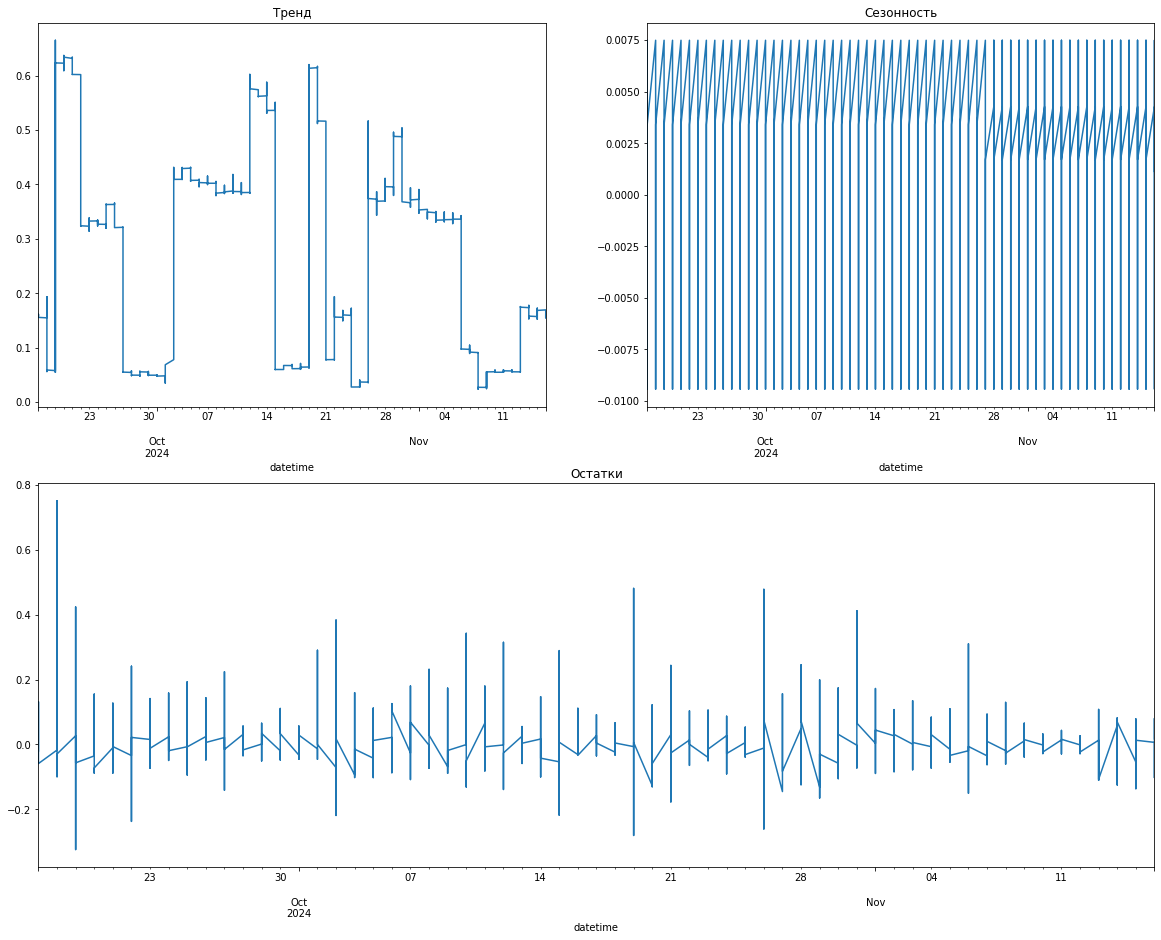

In [17]:
data.index = pd.PeriodIndex(data.index, freq='D')
decomposed = seasonal_decompose(data.cpu_req_util, period=48)

plt.figure(figsize=(20, 24))
plt.subplot(321)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(322)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.show()

In [18]:
october = decomposed.seasonal[(decomposed.seasonal.index >= '2024-10-01') & (decomposed.seasonal.index <= '2024-10-31')]

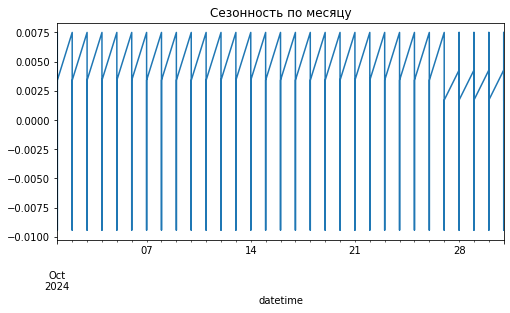

In [19]:
october.plot(title='Сезонность по месяцу', figsize=(8, 4))
plt.show()

### Добавление признаков

In [20]:
data = compile_pod_metrics(0)

Для целей настоящего исследования будем прогнозировать признак cpu_request_util - утилизация реквеста vCPU

In [21]:
data = data.drop(['cpu_request', 'cpu_usage_time'], axis=1)

Функция make_features добавляет новые признаки в виде смещенного по времени значения целевого признака на заданное количество шагов max_lag, а также скользящую среднюю по всему периоду смещения.

In [22]:
def make_features(data, max_lag):
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data.cpu_req_util.shift(lag)
    data['rolling_mean'] = data.cpu_req_util.shift().rolling(max_lag).mean()

Создадим дополнительные признаки:

In [23]:
make_features(data, 7)
data = data.fillna(0)
data.head(15)

,cpu_req_util,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,
2024-09-17 15:07:00,0.134,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000000
2024-09-17 15:17:00,0.153,0.134,0.000,0.000,0.000,0.000,0.000,0.000,0.000000
2024-09-17 15:27:00,0.154,0.153,0.134,0.000,0.000,0.000,0.000,0.000,0.000000
2024-09-17 15:37:00,0.128,0.154,0.153,0.134,0.000,0.000,0.000,0.000,0.000000
2024-09-17 15:47:00,0.202,0.128,0.154,0.153,0.134,0.000,0.000,0.000,0.000000
2024-09-17 15:57:00,0.197,0.202,0.128,0.154,0.153,0.134,0.000,0.000,0.000000
2024-09-17 16:07:00,0.141,0.197,0.202,0.128,0.154,0.153,0.134,0.000,0.000000
2024-09-17 16:17:00,0.146,0.141,0.197,0.202,0.128,0.154,0.153,0.134,0.158429
2024-09-17 16:27:00,0.215,0.146,0.141,0.197,0.202,0.128,0.154,0.153,0.160143


### Подготовка пайплайна

In [24]:
train, test = train_test_split(data, shuffle=False, test_size=0.12)
X_train, y_train = train.drop('cpu_req_util', axis=1), train.cpu_req_util
X_test, y_test = test.drop('cpu_req_util', axis=1), test.cpu_req_util

In [25]:
pipe_train =  Pipeline([
    ('models', 'passthrough')
])

In [26]:
linear = [
    {
        'models': [LinearRegression()],
        'models__n_jobs': range(2, 15)
    }
]

In [27]:
tree = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 50),
        'models__min_samples_leaf': range(2, 50),
        'models__max_depth': range(2, 50),
        'models__max_features': range(2, 50),
    }
]

In [28]:
knn = [
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 50),
    }
]

In [29]:
boosting = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__num_leaves': range(4, 20),
    } 
]

Создадим наборы из инициализированных выше комплектов настроек моделей:

In [30]:
model_set = [linear, tree, knn, boosting]

In [31]:
model_names = ['LinearRegression', 'DecisionTree', 'kNN', 'LightGBM']

Инициализируем экземпляры RandomizedSearchCV для всех моделей:

In [32]:
cv_tests = []
tscv = TimeSeriesSplit(n_splits=5)

for model in model_set:
    param_search = RandomizedSearchCV(
        pipe_train,
        model,
        n_jobs=-1,
        cv=tscv,
        n_iter=10,
        scoring='neg_root_mean_squared_error'
    )
    cv_tests.append(param_search)

### Подбор гиперпараметров

Выполним в цикле подбор гиперпараметров и запишем результаты в отдельные списки:

In [33]:
warnings.filterwarnings('ignore')
estimators = []
best_scores = []

model_pos = 0
for test in cv_tests:
    start = time.time()
    test.fit(X_train, y_train)
    finish = time.time()
    pd.set_option('display.max_colwidth', None)
    result = pd.DataFrame(test.cv_results_).sort_values(by='rank_test_score')
    estimators.append(test.best_estimator_)
    best_scores.append(max(result.mean_test_score) * -1)
    print(f'Модель {model_names[model_pos]} рассчитана за {int(finish - start)} сек. Результаты:')
    display(result[['mean_test_score', 'params']].head(3))
    model_pos += 1

test_results = pd.DataFrame(
    {'Модель': model_names,
     'RMSE': best_scores,
     'Параметры': estimators}).sort_values(by='RMSE').reset_index(drop=True)

test_results.RMSE = test_results.RMSE.round(3)
print('Итоговые результаты тестирования:')
test_results

Модель LinearRegression рассчитана за 5 сек. Результаты:


,mean_test_score,params
0,-0.048082,"{'models__n_jobs': 11, 'models': LinearRegression()}"
1,-0.048082,"{'models__n_jobs': 9, 'models': LinearRegression()}"
2,-0.048082,"{'models__n_jobs': 3, 'models': LinearRegression()}"


Модель DecisionTree рассчитана за 1 сек. Результаты:


,mean_test_score,params
3,-0.052448,"{'models__min_samples_split': 22, 'models__min_samples_leaf': 43, 'models__max_features': 27, 'models__max_depth': 18, 'models': DecisionTreeRegressor(random_state=88)}"
1,-0.052529,"{'models__min_samples_split': 46, 'models__min_samples_leaf': 42, 'models__max_features': 44, 'models__max_depth': 27, 'models': DecisionTreeRegressor(random_state=88)}"
0,-0.052533,"{'models__min_samples_split': 34, 'models__min_samples_leaf': 31, 'models__max_features': 29, 'models__max_depth': 17, 'models': DecisionTreeRegressor(random_state=88)}"


Модель kNN рассчитана за 1 сек. Результаты:


,mean_test_score,params
9,-0.050546,"{'models__n_neighbors': 22, 'models': KNeighborsRegressor()}"
8,-0.050609,"{'models__n_neighbors': 17, 'models': KNeighborsRegressor()}"
0,-0.050671,"{'models__n_neighbors': 30, 'models': KNeighborsRegressor()}"


Модель LightGBM рассчитана за 11 сек. Результаты:


,mean_test_score,params
5,-0.047642,"{'models__num_leaves': 6, 'models__max_depth': 4, 'models': LGBMRegressor(random_state=88)}"
0,-0.047747,"{'models__num_leaves': 8, 'models__max_depth': 4, 'models': LGBMRegressor(random_state=88)}"
8,-0.047922,"{'models__num_leaves': 11, 'models__max_depth': 3, 'models': LGBMRegressor(random_state=88)}"


Итоговые результаты тестирования:


,Модель,RMSE,Параметры
0,LightGBM,0.048,"(LGBMRegressor(max_depth=4, num_leaves=6, random_state=88))"
1,LinearRegression,0.048,(LinearRegression(n_jobs=11))
2,kNN,0.051,(KNeighborsRegressor(n_neighbors=22))
3,DecisionTree,0.052,"(DecisionTreeRegressor(max_depth=18, max_features=27, min_samples_leaf=43,\n min_samples_split=22, random_state=88))"


По результатам подбора параметров с кросс-валидацией лучшие результаты показала модель LightGBM со следующими параметрами:\
**LGBMRegressor(max_depth=4, num_leaves=6, random_state=88)**

### Расчет ориентира контрольной метрики

Проверим, какую ошибку даст модель, формирующая случайное предсказание:

In [34]:
dr = DummyRegressor(strategy='mean')
dr.fit(X_train, y_train)
y_pred_dummy = dr.predict(X_test)
dummy_err = root_mean_squared_error(y_test, y_pred_dummy)
print(f'Ошибка RMSE константной модели - {round(dummy_err, 3)}')

Ошибка RMSE константной модели - 0.211


### Тестирование лучшей модели

In [35]:
warnings.filterwarnings('ignore')
best_suite = LGBMRegressor(max_depth=4, num_leaves=6, random_state=88)
best_suite.fit(X_train, y_train)
y_pred = best_suite.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
print(f'Ошибка RMSE лучшей модели на тестовой выборке - {round(rmse, 3)}')

Ошибка RMSE лучшей модели на тестовой выборке - 0.037


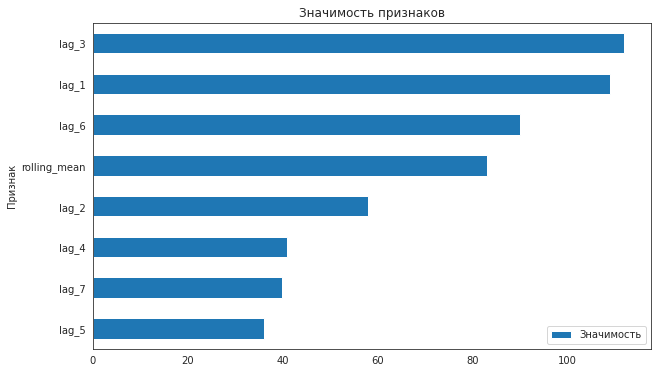

In [36]:
best_suite.fit(X_train, y_train)
coefficients = best_suite.feature_importances_
features_names = X_train.columns
feature_importance = pd.DataFrame({'Признак': features_names, 'Значимость': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Значимость', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Признак', y='Значимость', kind='barh', figsize=(10, 6))
plt.title('Значимость признаков')
plt.show()

### Итоговый вывод

По результатам проведенных исследований, можно утверждать, что при помощи модели градиентного бустинга LightGBM существует возможность прогнозирования реального потребления вычислительных ресурсов в пределах одного часа с точностью до 96,3%